# Data Load

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [2]:
os.chdir(r"C:\Users\ManosIeronymakisProb\OneDrive - Probability\Bureaublad\thesis temporary\PRO\MI4\CMPNY_ESG_CORE\W365_UDAI")

filepath = "merged_data_ESG_with_PermIDs.csv"
merged_df = pd.read_csv(filepath)

# Data preparation

In [4]:
# Calculate the total number of columns in merged_df
total_columns = len(merged_df.columns)

# Calculate the threshold for missing data
threshold = total_columns * 0.2

# Count the number of missing values in each row
missing_values_per_row = merged_df.isnull().sum(axis=1)

# Filter rows with less than 20% missing data
rows_less_than_20_percent_missing = merged_df[missing_values_per_row < threshold]

# Print the number of rows with less than 20% missing data
print("Number of rows with less than 20% missing data:", len(rows_less_than_20_percent_missing))

# Create a new DataFrame with rows that have less than 20% missing data
df_less_than_20_percent_missing = rows_less_than_20_percent_missing.copy()

# Drop 'id' and 'company name' columns as they're not needed for modeling
data = df_less_than_20_percent_missing.drop(["PermID",'Id',"Marketcap(B)"], axis=1)

# Forward fill missing values in the DataFrame separately for fast (F) and slow (S) ESG scores
fast_data_filled = data.iloc[:, :len(data.columns) // 2].ffill(axis=1)
slow_data_filled = data.iloc[:, len(data.columns) // 2:].ffill(axis=1)

# Backward fill missing values in the DataFrame separately for fast (F) and slow (S) ESG scores
fast_data_filled = fast_data_filled.bfill(axis=1)
slow_data_filled = slow_data_filled.bfill(axis=1)

# Concatenate the filled dataframes back together
data_filled = pd.concat([fast_data_filled, slow_data_filled], axis=1)

data_filled = data_filled.iloc[:-3]

dependent_variable = data_filled.loc[:, '2024S':'2005S']
reversed_dependent_variable = dependent_variable.loc[:, ::-1]

dependent_variable = reversed_dependent_variable
independent_variables = data_filled.loc[:, '2005F':'2024F']

dependent_variable.reset_index(drop=True, inplace=True)
independent_variables.reset_index(drop=True, inplace=True)

Number of rows with less than 20% missing data: 392


# Optimise ARIMA parameters in the validation set

Failed to fit ARIMA(1,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(2,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(3,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(4,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(5,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(1,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(2,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(3,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(4,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(5,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(1,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(2,0,3) for company index: Schur decomposition solver error.
Failed to fit ARIMA(3,0,3) for company i

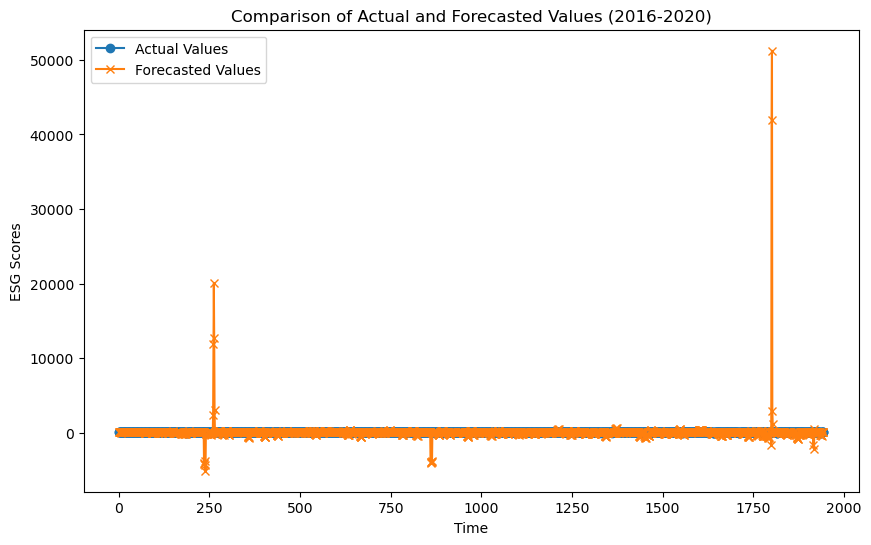

In [5]:
#find optimised parameters for the training years 2005-2015
warnings.filterwarnings("ignore")

train_start_year = 2005 #adjust based the years I want to train the model 
train_end_year = 2015
validation_start_year = 2016
validation_end_year = 2020

train_dep = dependent_variable.loc[:, f'{train_start_year}S':f'{train_end_year}S']
train_ind = independent_variables.loc[:, f'{train_start_year}F':f'{train_end_year}F']

validation_dep = dependent_variable.loc[:, f'{validation_start_year}S':f'{validation_end_year}S']
validation_ind = independent_variables.loc[:, f'{validation_start_year}F':f'{validation_end_year}F']

# Initialize a list to store optimized parameters and metrics
results_list = []

# Function to optimize ARIMA parameters
def optimize_arima_parameters(train_series_dep, train_series_ind, validation_series_dep, validation_series_ind, max_p=5, max_d=2, max_q=5):
    best_aic = float("inf")
    best_order = None
    best_mdl = None
    best_forecast = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(train_series_dep, order=(p, d, q), exog=train_series_ind)
                    fitted_model = model.fit()
                    forecast = fitted_model.forecast(steps=len(validation_series_dep), exog=validation_series_ind)
                    tmp_aic = fitted_model.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (p, d, q)
                        best_mdl = fitted_model
                        best_forecast = forecast
                except Exception as e:
                    print(f"Failed to fit ARIMA({p},{d},{q}) for company index: {e}")
                    continue
    return best_order, best_mdl, best_forecast

# Loop over each company to optimize parameters and evaluate model
predictions = []

for i in range(train_dep.shape[0]):
    train_series_dep = train_dep.iloc[i].astype(float)
    train_series_ind = train_ind.iloc[i].astype(float)
    validation_series_dep = validation_dep.iloc[i].astype(float)
    validation_series_ind = validation_ind.iloc[i].astype(float)

    if train_series_dep.isnull().any() or train_series_ind.isnull().any() or validation_series_dep.isnull().any() or validation_series_ind.isnull().any():
        print(f"Skipping company index {i} due to missing values in the series")
        results_list.append({
            'p': np.nan,
            'd': np.nan,
            'q': np.nan,
            'MAE': np.nan,
            'MSE': np.nan,
            'RMSE': np.nan,
            'MAPE': np.nan
        })
        continue

    # Align indices
    train_series_dep.index = pd.to_datetime(train_series_dep.index.str[:-1], format='%Y')
    train_series_ind.index = pd.to_datetime(train_series_ind.index.str[:-1], format='%Y')
    validation_series_dep.index = pd.to_datetime(validation_series_dep.index.str[:-1], format='%Y')
    validation_series_ind.index = pd.to_datetime(validation_series_ind.index.str[:-1], format='%Y')

    # Ensure the frequency is set
    train_series_dep.index.freq = train_series_dep.index.inferred_freq
    train_series_ind.index.freq = train_series_ind.index.inferred_freq
    validation_series_dep.index.freq = validation_series_dep.index.inferred_freq
    validation_series_ind.index.freq = validation_series_ind.index.inferred_freq

    best_order, best_mdl, best_forecast = optimize_arima_parameters(
        train_series_dep, train_series_ind, validation_series_dep, validation_series_ind
    )

    if best_order and best_forecast is not None:
        mae = mean_absolute_error(validation_series_dep, best_forecast)
        mse = mean_squared_error(validation_series_dep, best_forecast)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((validation_series_dep - best_forecast) / validation_series_dep)) * 100

        results_list.append({
            'p': best_order[0],
            'd': best_order[1],
            'q': best_order[2],
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape
        })

        predictions.append((validation_series_dep, best_forecast))
    else:
        print(f"No suitable model found for company index {i}")
        results_list.append({
            'p': np.nan,
            'd': np.nan,
            'q': np.nan,
            'MAE': np.nan,
            'MSE': np.nan,
            'RMSE': np.nan,
            'MAPE': np.nan
        })

results = pd.DataFrame(results_list)
print(results)

# Calculate overall metrics
if predictions:
    actuals = np.concatenate([pred[0] for pred in predictions if pred[0] is not None])
    forecasts = np.concatenate([pred[1] for pred in predictions if pred[1] is not None])

    mae = mean_absolute_error(actuals, forecasts)
    mse = mean_squared_error(actuals, forecasts)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - forecasts) / actuals)) * 100

    print(f"Overall Metrics - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Values', marker='o')
    plt.plot(forecasts, label='Forecasted Values', marker='x')
    plt.title('Comparison of Actual and Forecasted Values (2016-2020)')
    plt.xlabel('Time')
    plt.ylabel('ESG Scores')
    plt.legend()
    plt.show()
else:
    print("No predictions to evaluate")

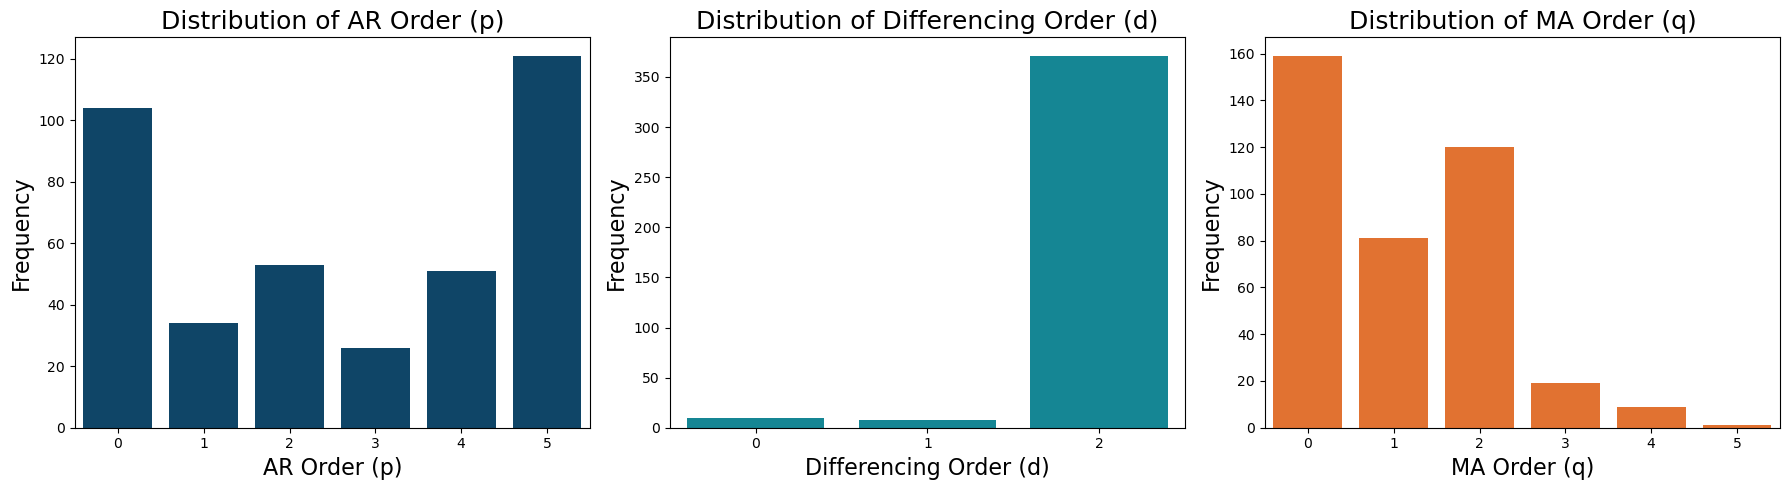

In [7]:
# Visualize distribution of optimized parameters
results['p'] = pd.to_numeric(results['p'], errors='coerce').fillna(0).astype(int)
results['d'] = pd.to_numeric(results['d'], errors='coerce').fillna(0).astype(int)
results['q'] = pd.to_numeric(results['q'], errors='coerce').fillna(0).astype(int)

colors = ['#004976', '#0097A9', '#FF6A13']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.countplot(x='p', data=results, ax=axes[0], color=colors[0])
axes[0].set_title('Distribution of AR Order (p)', fontsize=18)
axes[0].set_xlabel('AR Order (p)', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)

sns.countplot(x='d', data=results, ax=axes[1], color=colors[1])
axes[1].set_title('Distribution of Differencing Order (d)', fontsize=18)
axes[1].set_xlabel('Differencing Order (d)', fontsize=16)
axes[1].set_ylabel('Frequency', fontsize=16)

sns.countplot(x='q', data=results, ax=axes[2], color=colors[2])
axes[2].set_title('Distribution of MA Order (q)', fontsize=18)
axes[2].set_xlabel('MA Order (q)', fontsize=16)
axes[2].set_ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()

# ARIMA model with optimised parameters for our actuall train set

Company 0, Year 2020S: Actual = 54.84111287, Forecast = 57.37455370364064
Company 0, Year 2021S: Actual = 59.24656434, Forecast = 56.95961469422317
Company 0, Year 2022S: Actual = 53.15223343, Forecast = 58.374849062093936
Company 0, Year 2023S: Actual = 53.95750519, Forecast = 56.41730825618614
Company 0, Year 2024S: Actual = 50.06605061, Forecast = 56.09643008397386
Company 1, Year 2020S: Actual = 65.40898324, Forecast = 63.671106537203926
Company 1, Year 2021S: Actual = 69.04048723, Forecast = 72.38659472995235
Company 1, Year 2022S: Actual = 72.86696056, Forecast = 72.04092336488839
Company 1, Year 2023S: Actual = 74.54879695, Forecast = 75.00142238799923
Company 1, Year 2024S: Actual = 73.8999053, Forecast = 75.62043758624927
Company 2, Year 2020S: Actual = 77.60097421, Forecast = 79.32680696002765
Company 2, Year 2021S: Actual = 80.39613996, Forecast = 79.17140535946295
Company 2, Year 2022S: Actual = 81.78240111, Forecast = 85.17852026797995
Company 2, Year 2023S: Actual = 80.81

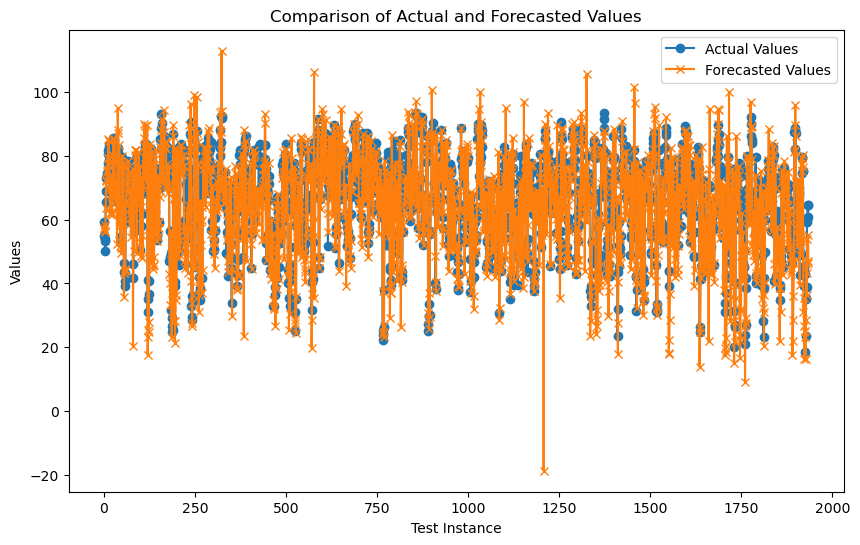

Mean Absolute Error (MAE): 6.381250799154341
Mean Squared Error (MSE): 83.48233181725809
Root Mean Squared Error (RMSE): 9.13686663015599
Mean Absolute Percentage Error (MAPE): 10.37%
Adjusted R-Squared: 0.56


In [2]:
#Run ARIMA model with optimised parameters for the years 2005-2020
# Column names for years
dep_years = [str(year) + 'S' for year in range(2005, 2025)]
ind_years = [str(year) + 'F' for year in range(2005, 2025)]

# Assuming results is your DataFrame from the ADF test with added 'p', 'q', 'd' columns
prediction_start_year = 2020
prediction_end_year = 2024

# Calculate the indexes for these years in your dataframe columns
start_index = dep_years.index(str(prediction_start_year) + 'S')
end_index = dep_years.index(str(prediction_end_year) + 'S')

results_list = []

for idx in range(len(dependent_variable)):  # Loop over each company
    dep_data = dependent_variable.loc[idx, dep_years].astype(float)
    ind_data = independent_variables.loc[idx, ind_years].astype(float)

    # Retrieve the optimal ARIMA parameters for the current company
    p = int(results.loc[idx, 'p'])
    q = int(results.loc[idx, 'q'])
    d = int(results.loc[idx, 'd'])

    # Start predicting from the start_index, training window is adjusted dynamically
    for end in range(start_index, end_index + 1):
        start = end - 15  # Adjust the window size (e.g., 15 years)
        if start < 0:
            continue  # Skip if the start index is out of bounds

        train_dep = dep_data[start:end]
        train_ind = ind_data[start:end]

        test_dep = dep_data[end]
        test_ind = ind_data[end]

        # Ensure alignment by resetting indexes
        train_dep.index = range(len(train_dep))
        train_ind.index = range(len(train_ind))

        try:
            model = ARIMA(train_dep, order=(p, d, q), exog=train_ind)
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=1, exog=pd.DataFrame([test_ind]))

            results_list.append((test_dep, forecast.iloc[0]))
            print(f"Company {idx}, Year {dep_years[end]}: Actual = {test_dep}, Forecast = {forecast.iloc[0]}")

        except Exception as e:
            print(f"Error for company at index {idx}, year {dep_years[end]}: {e}")

if results_list:
    actuals, forecasts = zip(*results_list)
    actuals = pd.Series(actuals)
    forecasts = pd.Series(forecasts)

    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Values', marker='o')
    plt.plot(forecasts, label='Forecasted Values', marker='x')
    plt.title('Comparison of Actual and Forecasted Values')
    plt.xlabel('Test Instance')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(actuals, forecasts)
    mse = mean_squared_error(actuals, forecasts)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - forecasts) / actuals)) * 100
    r2 = r2_score(actuals, forecasts)
    n = len(actuals)  # Number of observations
    p = 10  # Number of predictors, adjust this as per model's exogenous variables
    adjusted_r_squared = 1 - (1-r2)*(n-1)/(n-p-1)
    
    
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Adjusted R-Squared: {adjusted_r_squared:.2f}")

else:
    print("No forecasts were generated, please check the input data and model configuration.")


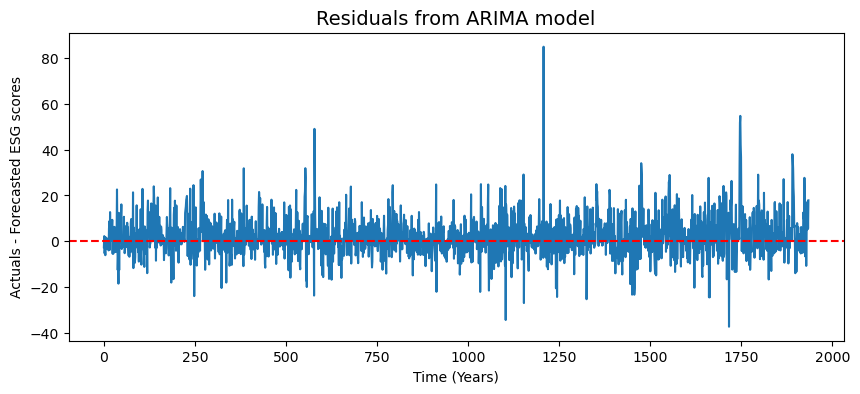

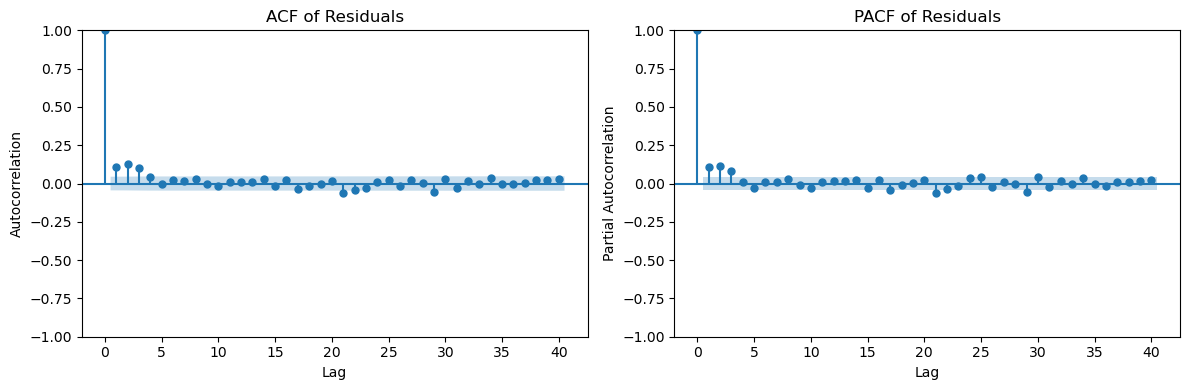

In [3]:
# plot residuals

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Calculate residuals
residuals = [actuals[i] - forecasts[i] for i in range(len(actuals))]

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from ARIMA model', fontsize=14)
plt.xlabel('Time (Years)')
plt.ylabel('Actuals - Forecasted ESG scores')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0])
ax[0].set_title('ACF of Residuals')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')

sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1])
ax[1].set_title('PACF of Residuals')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

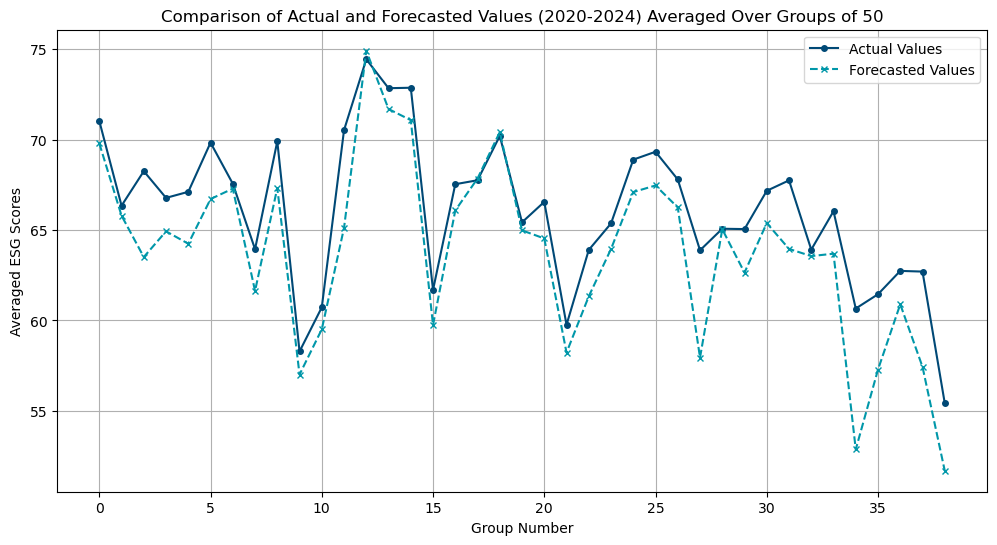

In [4]:
# plot actuals vs predicted

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'results' is your list of tuples with (actual, forecasted) values
results_list = [(actual, forecast) for actual, forecast in results_list]  # Replace with your actual data list

# Convert the list of tuples into a DataFrame
data = pd.DataFrame(results_list, columns=['Actual Values', 'Forecasted Values'])

# Grouping data into averages of 50 data points each
group_size = 50
data['Group'] = np.arange(len(data)) // group_size
grouped_data = data.groupby('Group').mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(grouped_data['Actual Values'], label='Actual Values', marker='o', linestyle='-', markersize=4, color='#004976')
plt.plot(grouped_data['Forecasted Values'], label='Forecasted Values', marker='x', linestyle='--', markersize=4,color='#0097A9')
plt.title('Comparison of Actual and Forecasted Values (2020-2024) Averaged Over Groups of 50')
plt.xlabel('Group Number')
plt.ylabel('Averaged ESG Scores')
plt.legend()
plt.grid(True)
plt.show()


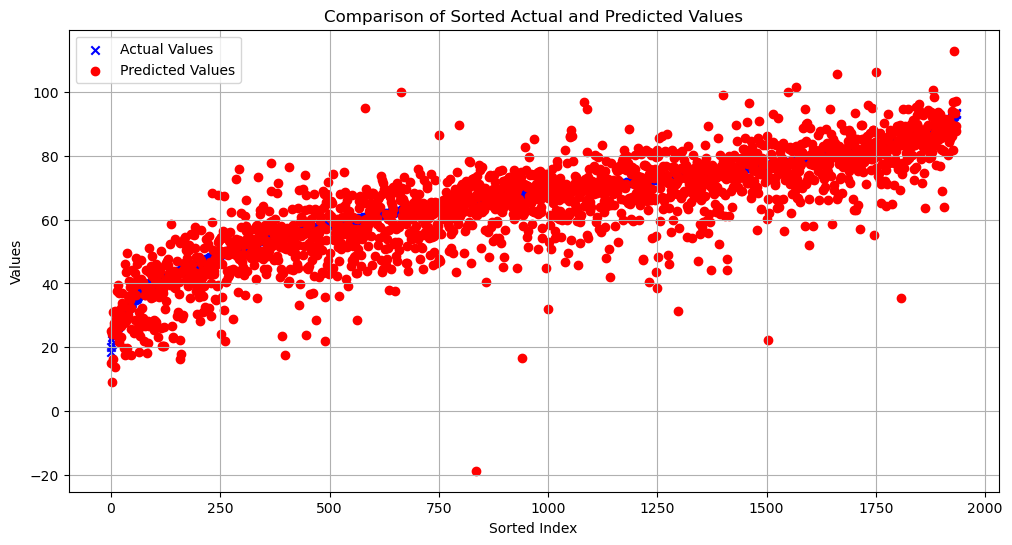

In [5]:
# plot RMSE
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'results' is your list of tuples with (actual, forecasted) values
result_list = [(actual, forecast) for actual, forecast in results_list]  # Replace with your actual data list

# Convert the list of tuples into a DataFrame
data = pd.DataFrame(results_list, columns=['Actual Values', 'Forecasted Values'])

# Sort data by actual values in ascending order
sorted_data = data.sort_values(by='Actual Values').reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 6))
# Actual points
plt.scatter(range(len(sorted_data)), sorted_data['Actual Values'], color='blue', label='Actual Values', marker='x')

# Predicted points
plt.scatter(range(len(sorted_data)), sorted_data['Forecasted Values'], color='red', label='Predicted Values', marker='o')

# Enhancing the plot
plt.title('Comparison of Sorted Actual and Predicted Values')
plt.xlabel('Sorted Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

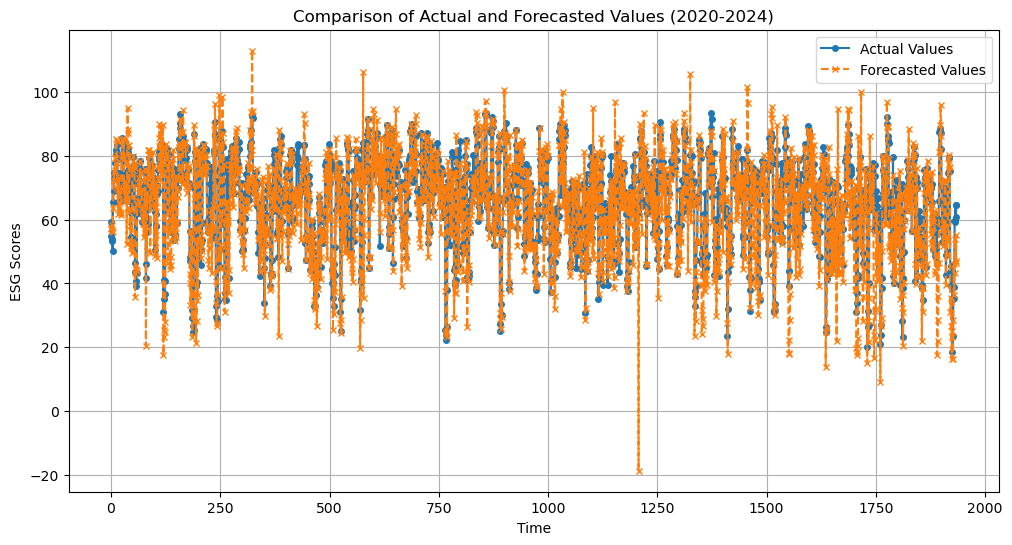

In [6]:
#Results is the list of tuples with (actual, forecasted) values
results_list = [(actual, forecast) for actual, forecast in results_list]  # Replace with your actual data list

# Convert the list of tuples into a DataFrame
data = pd.DataFrame(results_list, columns=['Actual Values', 'Forecasted Values'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['Actual Values'], label='Actual Values', marker='o', linestyle='-', markersize=4)
plt.plot(data['Forecasted Values'], label='Forecasted Values', marker='x', linestyle='--', markersize=4)
plt.title('Comparison of Actual and Forecasted Values (2020-2024)')
plt.xlabel('Time')
plt.ylabel('ESG Scores')
plt.legend()
plt.grid(True)
plt.show()